# Time Series Anomaly Detection using LSTM Autoencoders with PyTorch in Python

In [1]:
# DATA: http://timeseriesclassification.com/description.php?Dataset=ECG5000
# Notebook: https://curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/

In [2]:
!nvidia-smi

Fri Dec 30 11:16:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 6000     Off  | 00000000:01:00.0 Off |                  Off |
| 33%   33C    P8     3W / 260W |     15MiB / 24217MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
! nvidia-smi --gpu-reset

GPU Reset couldn't run because GPU 00000000:01:00.0 is the primary GPU.


In [6]:
# ! pip install --upgrade pip

# ! pip install pandas

# ! pip install torch==1.13.0
# ! pip install torchvision==0.14.0

# ! pip3 install --ignore-installed torch torchvision torchaudio

# ! pip install -qq arff arff2pandas
! pip install -q -U watermark
# ! pip install -qq -U pandas seaborn
#
# ! pip install captum
! pip install shap
# ! pip install lime

%reload_ext watermark
%watermark -v -p numpy,pandas,torch,torchvision,arff2pandas

Defaulting to user installation because normal site-packages is not writeable
--- Logging error ---
Traceback (most recent call last):
  File "/home/mmozolewski/.local/lib/python3.8/site-packages/pip/_internal/utils/logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "/home/mmozolewski/.local/lib/python3.8/site-packages/pip/_vendor/rich/console.py", line 1752, in print
    extend(render(renderable, render_options))
  File "/home/mmozolewski/.local/lib/python3.8/site-packages/pip/_vendor/rich/console.py", line 1390, in render
    for render_output in iter_render:
  File "/home/mmozolewski/.local/lib/python3.8/site-packages/pip/_internal/utils/logging.py", line 134, in __rich_console__
    for line in lines:
  File "/home/mmozolewski/.local/lib/python3.8/site-packages/pip/_vendor/rich/segment.py", line 245, in split_lines
    for segment in segments:
  File "/home/mmozolewski/.local/lib/python3.8/site-packages/pip/_vendor/r

ModuleNotFoundError: No module named 'watermark'

In [ ]:
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
# from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

# import torch.nn.functional as F
# from arff2pandas import a2p
from scipy.io.arff import loadarff

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

import shap
import lime

from captum.attr import (
  GradientShap,
  DeepLift,
  DeepLiftShap,
  IntegratedGradients,
  LayerConductance,
  NeuronConductance,
  NoiseTunnel,
  GuidedGradCam,
)

In this tutorial, you'll learn how to detect anomalies in Time Series data using an LSTM Autoencoder. You're going to use real-world ECG data from a single patient with heart disease to detect abnormal hearbeats.

- [Read the tutorial](https://www.curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1_J2MrBSvsJfOcVmYAN2-WSp36BtsFZCa)
- [Read the Getting Things Done with Pytorch book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

By the end of this tutorial, you'll learn how to:

- Prepare a dataset for Anomaly Detection from Time Series Data
- Build an LSTM Autoencoder with PyTorch
- Train and evaluate your model
- Choose a threshold for anomaly detection
- Classify unseen examples as normal or anomaly

## Data



The [dataset](http://timeseriesclassification.com/description.php?Dataset=ECG5000) contains 5,000 Time Series examples (obtained with ECG) with 140 timesteps. Each sequence corresponds to a single heartbeat from a single patient with congestive heart failure.

> An electrocardiogram (ECG or EKG) is a test that checks how your heart is functioning by measuring the electrical activity of the heart. With each heart beat, an electrical impulse (or wave) travels through your heart. This wave causes the muscle to squeeze and pump blood from the heart. [Source](https://www.heartandstroke.ca/heart/tests/electrocardiogram)

We have 5 types of hearbeats (classes):

- Normal (N) 
- R-on-T Premature Ventricular Contraction (R-on-T PVC)
- Premature Ventricular Contraction (PVC)
- Supra-ventricular Premature or Ectopic Beat (SP or EB) 
- Unclassified Beat (UB).

> Assuming a healthy heart and a typical rate of 70 to 75 beats per minute, each cardiac cycle, or heartbeat, takes about 0.8 seconds to complete the cycle.
Frequency: 60–100 per minute (Humans)
Duration: 0.6–1 second (Humans) [Source](https://en.wikipedia.org/wiki/Cardiac_cycle)

The dataset is available on my Google Drive. Let's get it:

In [ ]:
# !gdown --id 16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT

Downloading...
From: https://drive.google.com/uc?id=16MIleqoIr1vYxlGk4GKnGmrsCPuWkkpT
To: /content/ECG5000.zip
10.6MB [00:00, 40.1MB/s]


In [ ]:
# !unzip -qq ECG5000.zip

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


The data comes in multiple formats. We'll load the `arff` files into Pandas data frames:

In [6]:
DATA_DIRECTORY = '/home/mmozolewski/notebooks/Introduction-to-Time-Series-Clustering/data-ecg/'

train = pd.DataFrame(loadarff(f'{DATA_DIRECTORY}ECG5000_TRAIN.arff')[0])
test = pd.DataFrame(loadarff(f'{DATA_DIRECTORY}ECG5000_TEST.arff')[0])

# with open(f'{DATA_DIRECTORY}ECG5000_TRAIN.arff') as f:
#   train = a2p.load(f)
#
# with open(f'{DATA_DIRECTORY}ECG5000_TEST.arff') as f:
#   test = a2p.load(f)

We'll combine the training and test data into a single data frame. This will give us more data to train our Autoencoder. We'll also shuffle it:

In [7]:
df = train.append(test)
df = df.sample(frac=1.0)
df.shape

(5000, 141)

In [10]:
df.head()

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att132,att133,att134,att135,att136,att137,att138,att139,att140,target
1001,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.822570,-3.003609,-1.799773,-1.500033,-1.025095,...,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932,b'1'
2086,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.554540,-1.699639,-1.566366,-1.038815,-0.425483,...,1.008577,1.024698,1.051141,1.015352,0.988475,1.050191,1.089509,1.465382,0.799517,b'1'
2153,-1.187772,-3.365038,-3.695653,-4.094781,-3.992549,-3.425381,-2.057643,-1.277729,-1.307397,-0.623098,...,1.085007,1.467196,1.413850,1.283822,0.923126,0.759235,0.932364,1.216265,-0.824489,b'1'
555,0.604969,-1.671363,-3.236131,-3.966465,-4.067820,-3.551897,-2.582864,-1.804755,-1.688151,-1.025897,...,0.545222,0.649363,0.986846,1.234495,1.280039,1.215985,1.617971,2.196543,0.023843,b'1'
205,-1.197203,-3.270123,-3.778723,-3.977574,-3.405060,-2.392634,-1.726322,-1.572748,-0.920075,-0.388731,...,0.828168,0.914338,1.063077,1.393479,1.469756,1.392281,1.144732,1.668263,1.734676,b'1'


We have 5,000 examples. Each row represents a single heartbeat record. Let's name the possible classes:

In [8]:
CLASS_NORMAL = 1

class_names = ['Normal','R on T','PVC','SP','UB']

Next, we'll rename the last column to `target`, so its easier to reference it:

In [9]:
new_columns = list(df.columns)
new_columns[-1] = 'target'
df.columns = new_columns

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 1001 to 360
Columns: 141 entries, att1 to target
dtypes: float64(140), object(1)
memory usage: 5.4+ MB


## Exploratory Data Analysis

Let's check how many examples for each heartbeat class do we have:

In [10]:
df.target = df.target.astype('int32')
df.target.value_counts()

1    2919
2    1767
4     194
3      96
5      24
Name: target, dtype: int64

Let's plot the results:

In [11]:
# df.target#.astype('str')

['Normal', 'R on T', 'PVC', 'SP', 'UB']


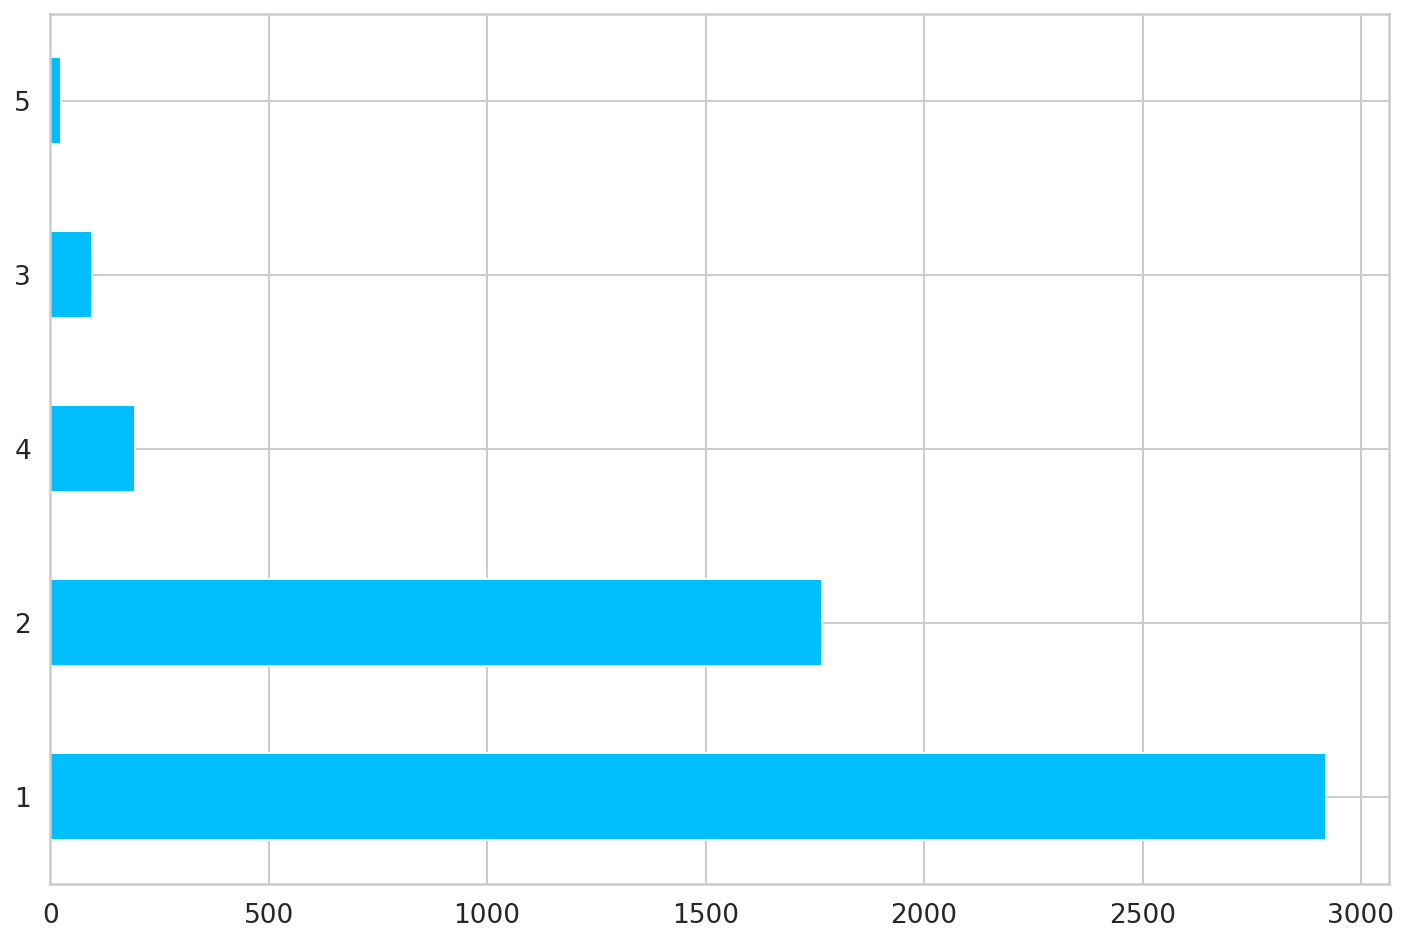

In [14]:
# ax = sns.countplot(df[["target"]])
# ax.set_xticklabels(class_names);
df['target'].value_counts().plot(kind='barh')
print(class_names)

The normal class, has by far, the most examples. This is great because we'll use it to train our model.

Let's have a look at an averaged (smoothed out with one standard deviation on top and bottom of it) Time Series for each class:

In [11]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name)

In [12]:
classes = df.target.unique()
print(classes)

[1 3 2 4 5]


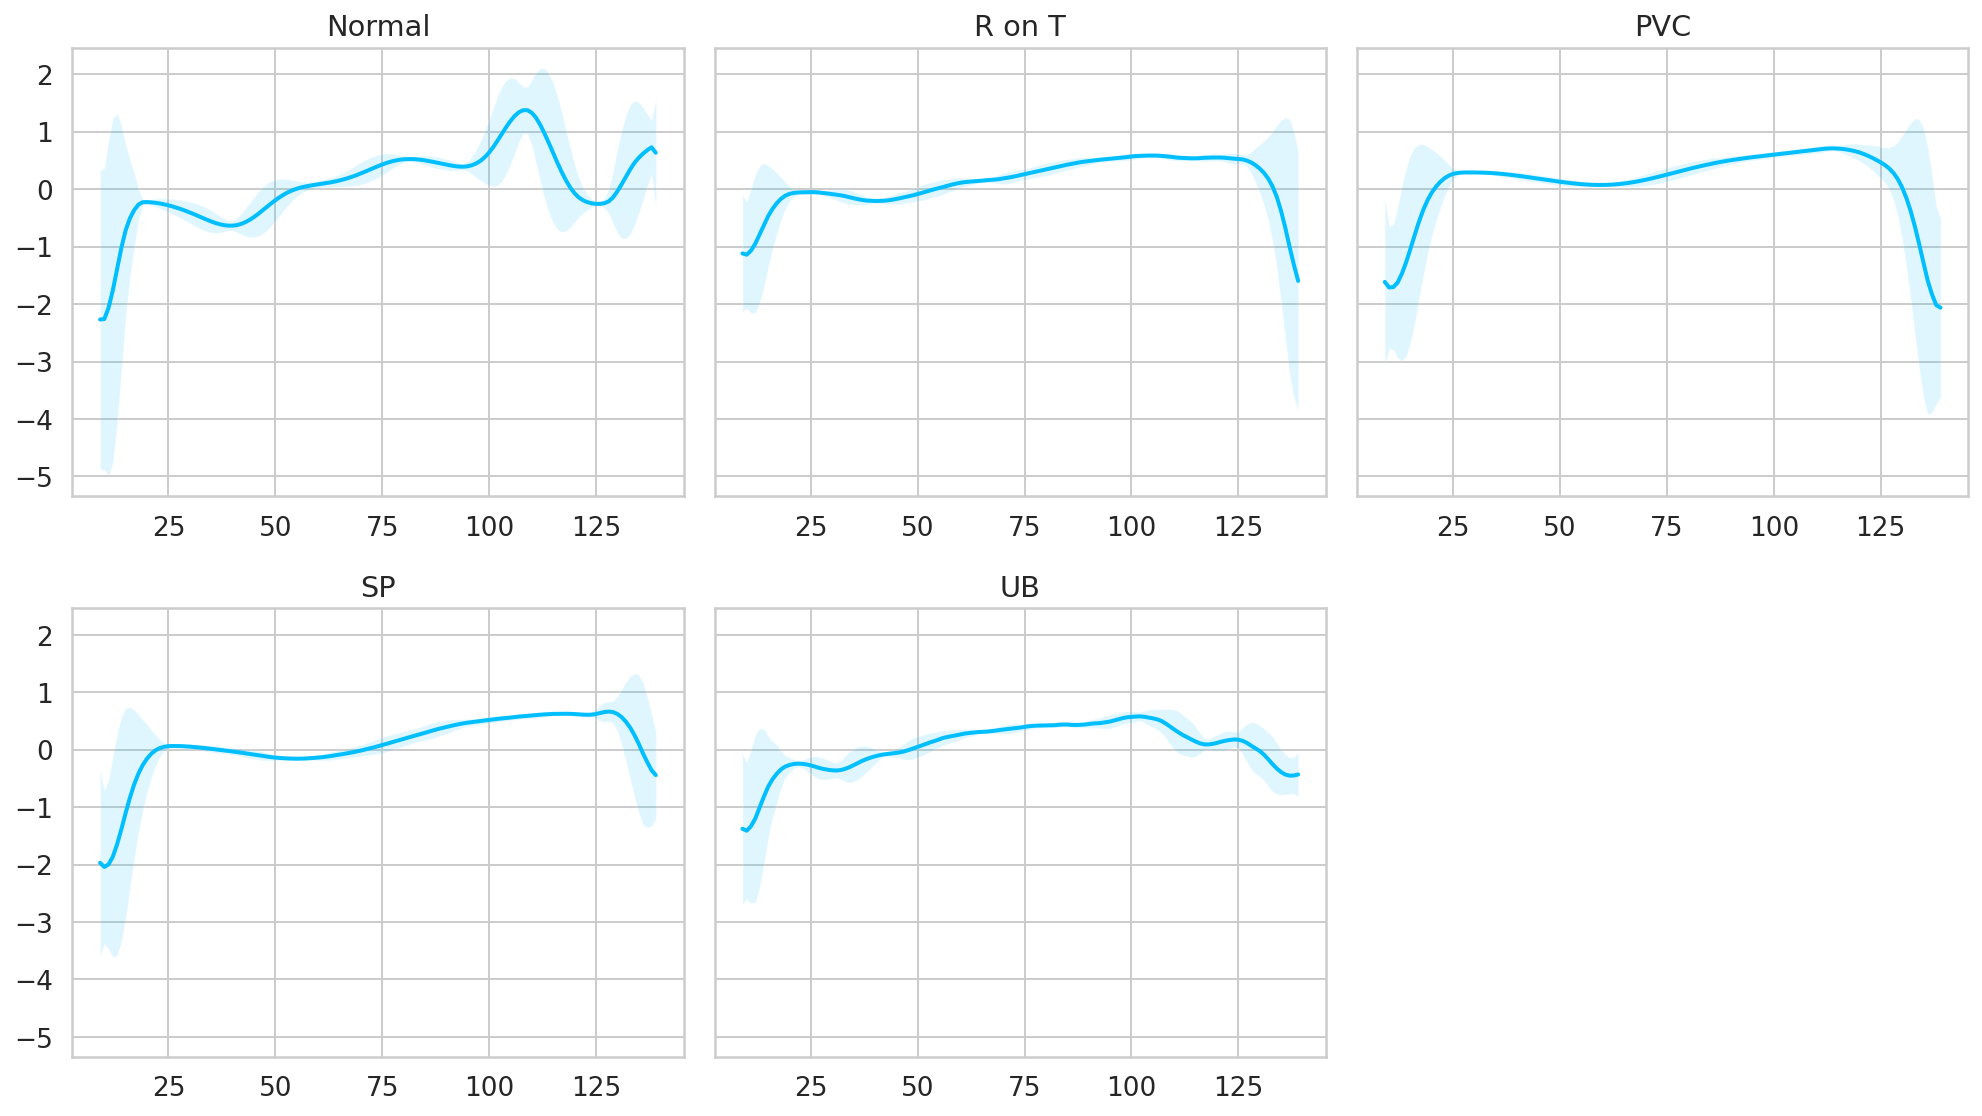

In [13]:
fig, axs = plt.subplots(
  nrows=len(classes) // 3 + 1,
  ncols=3,
  sharey=True,
  figsize=(14, 8)
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
  plot_time_series_class(data, class_names[i], ax)

fig.delaxes(axs.flat[-1])
fig.tight_layout();

It is very good that the normal class has a distinctly different pattern than all other classes. Maybe our model will be able to detect anomalies?

## LSTM Autoencoder

The [Autoencoder's](https://en.wikipedia.org/wiki/Autoencoder) job is to get some input data, pass it through the model, and obtain a reconstruction of the input. The reconstruction should match the input as much as possible. The trick is to use a small number of parameters, so your model learns a compressed representation of the data.

In a sense, Autoencoders try to learn only the most important features (compressed version) of the data. Here, we'll have a look at how to feed Time Series data to an Autoencoder. We'll use a couple of LSTM layers (hence the LSTM Autoencoder) to capture the temporal dependencies of the data.

To classify a sequence as normal or an anomaly, we'll pick a threshold above which a heartbeat is considered abnormal.

### Reconstruction Loss

When training an Autoencoder, the objective is to reconstruct the input as best as possible. This is done by minimizing a loss function (just like in supervised learning). This function is known as *reconstruction loss*. Cross-entropy loss and Mean squared error are common examples.

## Anomaly Detection in ECG Data

We'll use normal heartbeats as training data for our model and record the *reconstruction loss*. But first, we need to prepare the data:

### Data Preprocessing

Let's get all normal heartbeats and drop the target (class) column:

In [14]:
normal_df = df[df.target == CLASS_NORMAL].drop(labels='target', axis=1)
normal_df.shape

(2919, 140)

We'll merge all other classes and mark them as anomalies:

In [19]:
normal_df

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att131,att132,att133,att134,att135,att136,att137,att138,att139,att140
1001,1.469756,-1.048520,-3.394356,-4.254399,-4.162834,-3.822570,-3.003609,-1.799773,-1.500033,-1.025095,...,0.873347,0.945178,1.275588,1.617218,1.580279,1.306195,1.351674,1.915517,1.672103,-1.039932
2086,-1.998602,-3.770552,-4.267091,-4.256133,-3.515288,-2.554540,-1.699639,-1.566366,-1.038815,-0.425483,...,1.028602,1.008577,1.024698,1.051141,1.015352,0.988475,1.050191,1.089509,1.465382,0.799517
2153,-1.187772,-3.365038,-3.695653,-4.094781,-3.992549,-3.425381,-2.057643,-1.277729,-1.307397,-0.623098,...,0.972686,1.085007,1.467196,1.413850,1.283822,0.923126,0.759235,0.932364,1.216265,-0.824489
555,0.604969,-1.671363,-3.236131,-3.966465,-4.067820,-3.551897,-2.582864,-1.804755,-1.688151,-1.025897,...,0.509497,0.545222,0.649363,0.986846,1.234495,1.280039,1.215985,1.617971,2.196543,0.023843
205,-1.197203,-3.270123,-3.778723,-3.977574,-3.405060,-2.392634,-1.726322,-1.572748,-0.920075,-0.388731,...,0.299639,0.828168,0.914338,1.063077,1.393479,1.469756,1.392281,1.144732,1.668263,1.734676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185,-1.646498,-3.738094,-3.742831,-3.535569,-3.032323,-1.869597,-0.489063,-0.167220,0.516871,1.153570,...,-0.235311,-0.133717,0.024959,0.045702,-0.143185,-0.546866,-0.276909,-0.352712,-1.119149,-3.963702
130,2.564179,1.613262,-1.095212,-2.503290,-3.941101,-4.111999,-3.045872,-1.826329,-1.475444,-0.872021,...,-0.760417,-0.644936,-0.186302,0.216223,0.181220,0.804164,1.124791,1.505852,0.897723,0.814719
2419,-0.783554,-2.687134,-4.112973,-4.406401,-3.390553,-2.415967,-1.807586,-1.316739,-0.514625,-0.194878,...,1.320817,1.923486,1.385655,1.307225,1.067614,0.553204,0.130626,-0.382407,0.361591,0.308967
2592,-1.032096,-2.811901,-3.588706,-3.883206,-3.279964,-2.275187,-1.771033,-1.603019,-0.956392,-0.764538,...,1.383992,1.280471,1.353143,1.526594,1.429218,1.099634,1.245052,1.568047,1.776520,0.750669


In [15]:
anomaly_df = df[df.target != CLASS_NORMAL].drop(labels='target', axis=1)
anomaly_df.shape

(2081, 140)

We'll split the normal examples into train, validation and test sets:

In [21]:
anomaly_df

,att1,att2,att3,att4,att5,att6,att7,att8,att9,att10,...,att131,att132,att133,att134,att135,att136,att137,att138,att139,att140
3043,-0.321236,-1.461367,-2.365966,-2.812644,-3.068974,-3.223771,-3.089063,-2.708512,-2.105889,-1.587635,...,1.734849,1.634221,1.271049,0.722839,0.022662,-0.547250,-1.499344,-2.358348,-2.601288,-2.098543
2851,-0.944327,-2.325608,-3.359758,-3.983659,-4.036466,-3.823508,-3.567497,-2.966022,-1.921887,-1.164849,...,-0.278896,-0.767044,-1.302189,-2.150204,-2.518930,-1.840903,-0.764218,0.083810,0.495001,0.326526
4267,0.294981,-0.651842,-1.314702,-1.836148,-1.930226,-1.995267,-2.110644,-2.097992,-1.839687,-1.446685,...,-1.365440,-2.084077,-2.614123,-3.297312,-3.881822,-4.233724,-3.883198,-2.741736,-2.375971,-0.870357
3566,-0.641464,-2.102731,-3.257956,-3.591687,-3.456362,-3.170927,-2.607660,-1.783062,-1.187110,-1.114240,...,0.023183,-0.498398,-1.044345,-1.610290,-2.137711,-3.012836,-3.220379,-2.477407,-1.097606,0.312561
333,0.679824,-0.863884,-2.298195,-3.186748,-3.415058,-3.265813,-3.011455,-2.592667,-1.773994,-1.179463,...,-0.438838,-0.738676,-1.330490,-1.927671,-2.364053,-2.934549,-3.394048,-2.950691,-1.832853,-0.100349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2671,-0.524272,-1.470707,-2.292839,-2.522074,-2.526174,-2.461099,-2.313229,-2.076225,-1.428845,-0.848644,...,0.712983,-0.021880,-0.469170,-0.801520,-0.938977,-1.175771,-1.922718,-2.388551,-2.508298,-2.559652
2944,-1.193396,-1.945671,-2.191758,-2.632716,-2.675020,-2.632104,-2.643643,-2.453716,-2.183547,-1.777800,...,-1.200245,-1.717539,-2.401493,-2.959685,-3.316229,-3.437866,-2.882834,-1.922850,-1.128857,-0.045650
3926,-0.248881,-1.346474,-1.855199,-2.519039,-2.947360,-3.233288,-3.087431,-2.668242,-1.970671,-1.390033,...,-0.575139,-1.157266,-1.605818,-2.286109,-3.247334,-3.551343,-3.426098,-2.171479,-1.380595,-0.378163
466,-0.287286,-1.199089,-1.563916,-2.078314,-2.456073,-2.508211,-2.465002,-2.445333,-2.320656,-1.995150,...,-1.517807,-2.061417,-2.679767,-3.228270,-3.584828,-3.629377,-3.000843,-2.079477,-1.307187,0.075742


In [16]:
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33,
  random_state=RANDOM_SEED
)

We need to convert our examples into tensors, so we can use them to train our Autoencoder. Let's write a helper function for that:

In [17]:
def create_dataset(df):
  sequences = df.astype(np.float32).to_numpy().tolist()
  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

Each Time Series will be converted to a 2D Tensor in the shape *sequence length* x *number of features* (140x1 in our case).

Let's create some datasets:

In [18]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

print(f"train_dataset: {len(train_dataset)}")
print(f"val_dataset: {len(val_dataset)}")
print(f"test_normal_dataset: {len(test_normal_dataset)}")
print(f"test_anomaly_dataset: {len(test_anomaly_dataset)}")

train_dataset: 2481
val_dataset: 293
test_normal_dataset: 145
test_anomaly_dataset: 2081


### LSTM Autoencoder

![Autoencoder](https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png)
*Sample Autoencoder Architecture [Image Source](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html)*

The general Autoencoder architecture consists of two components. An *Encoder* that compresses the input and a *Decoder* that tries to reconstruct it.

We'll use the LSTM Autoencoder from this [GitHub repo](https://github.com/shobrook/sequitur) with some small tweaks. Our model's job is to reconstruct Time Series data. Let's start with the *Encoder*:

In [19]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

The *Encoder* uses two LSTM layers to compress the Time Series data input.

Next, we'll decode the compressed representation using a *Decoder*:

In [20]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

Our Decoder contains two LSTM layers and an output layer that gives the final reconstruction.

Time to wrap everything into an easy to use module:

In [21]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

Our Autoencoder passes the input through the Encoder and Decoder. Let's create an instance of it:

## SKIP TO MODEL LOAD

In [22]:
autoencoder_model = RecurrentAutoencoder(seq_len, n_features, 128)
autoencoder_model = autoencoder_model.to(device)

## Training

Let's write a helper function for our training process:

In [29]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0
  
  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.to(device)
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss}, val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

At each epoch, the training process feeds our model with all training examples and evaluates the performance on the validation set. Note that we're using a batch size of 1 (our model sees only 1 sequence at a time). We also record the training and validation set losses during the process.

Note that we're minimizing the [L1Loss](https://pytorch.org/docs/stable/nn.html#l1loss), which measures the MAE (mean absolute error). Why? The reconstructions seem to be better than with MSE (mean squared error).

We'll get the version of the model with the smallest validation error. Let's do some training:

In [30]:
autoencoder_model, history = train_model(
  autoencoder_model,
  train_dataset, 
  val_dataset, 
  n_epochs=150
)

Epoch 1: train loss 65.72745188336755, val loss 56.743454786697754
Epoch 2: train loss 55.194660771042045, val loss 54.246041763357745


KeyboardInterrupt: 

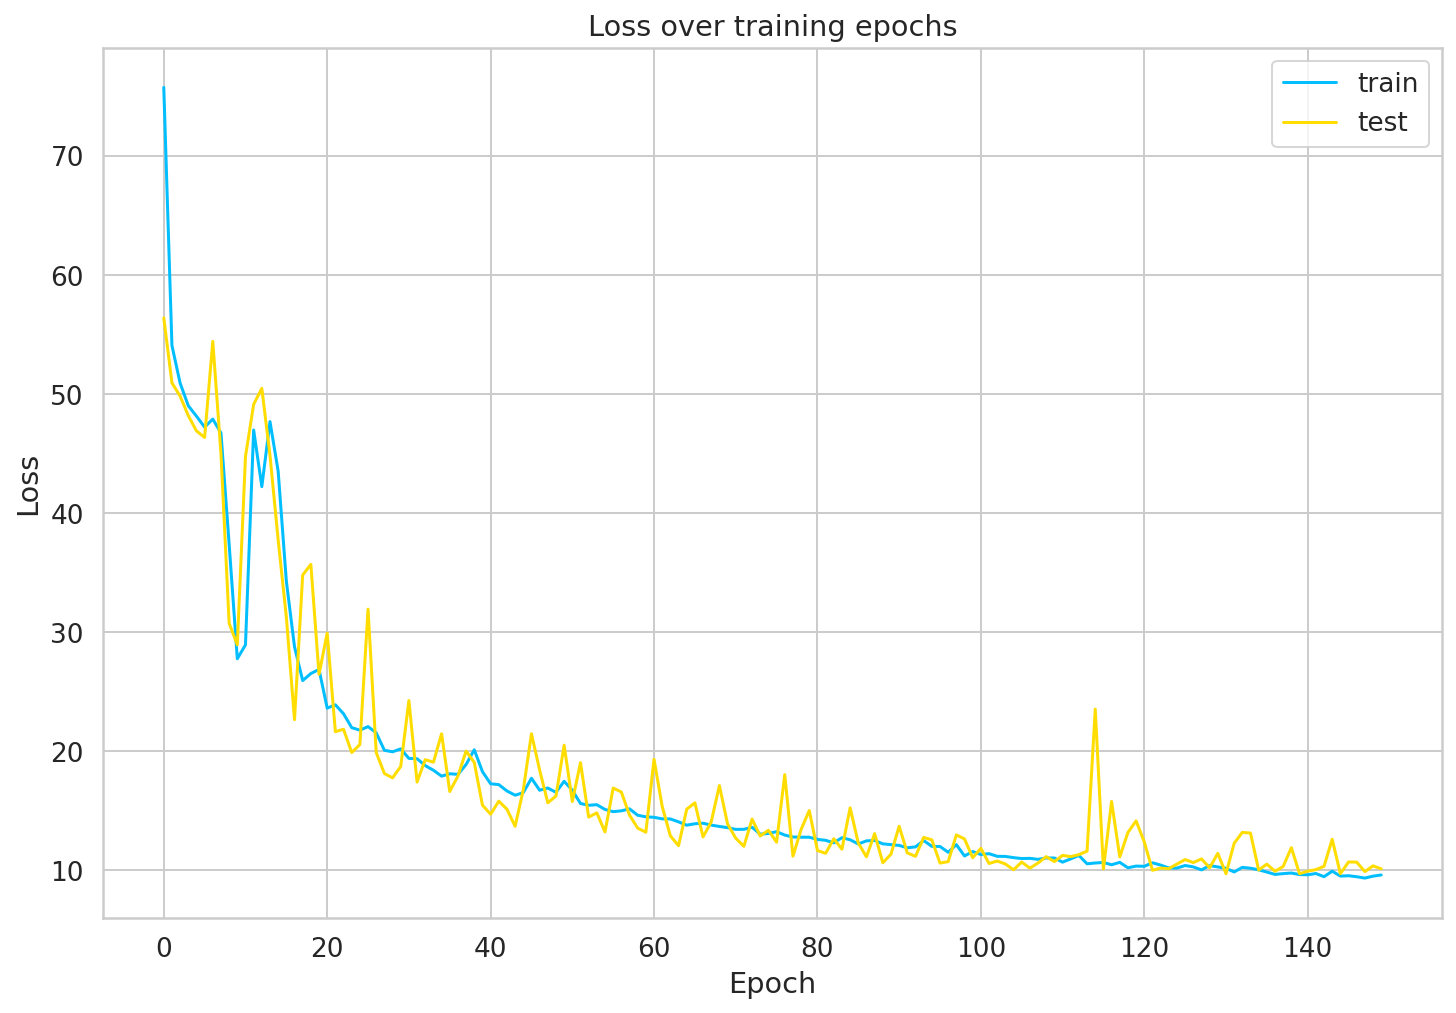

In [ ]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

Our model converged quite well. Seems like we might've needed a larger validation set to smoothen the results, but that'll do for now.

## Saving the model

Let's store the model for later use:

In [ ]:
MODEL_PATH = f'{DATA_DIRECTORY}model.pth'

torch.save(autoencoder_model, MODEL_PATH)

Uncomment the next lines, if you want to download and load the pre-trained model:

In [23]:
# !gdown --id 1jEYx5wGsb7Ix8cZAw3l5p5pOwHs3_I9A
autoencoder_model = torch.load(f'{DATA_DIRECTORY}model.pth')
autoencoder_model = autoencoder_model.to(device)
autoencoder_model

source code of class 'torch.nn.modules.rnn.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.


RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 256, batch_first=True)
    (rnn2): LSTM(256, 128, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(128, 128, batch_first=True)
    (rnn2): LSTM(128, 256, batch_first=True)
    (output_layer): Linear(in_features=256, out_features=1, bias=True)
  )
)

## Choosing a threshold

With our model at hand, we can have a look at the reconstruction error on the training set. Let's start by writing a helper function to get predictions from our model:

In [24]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

Our function goes through each example in the dataset and records the predictions and losses. Let's get the losses and have a look at them:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



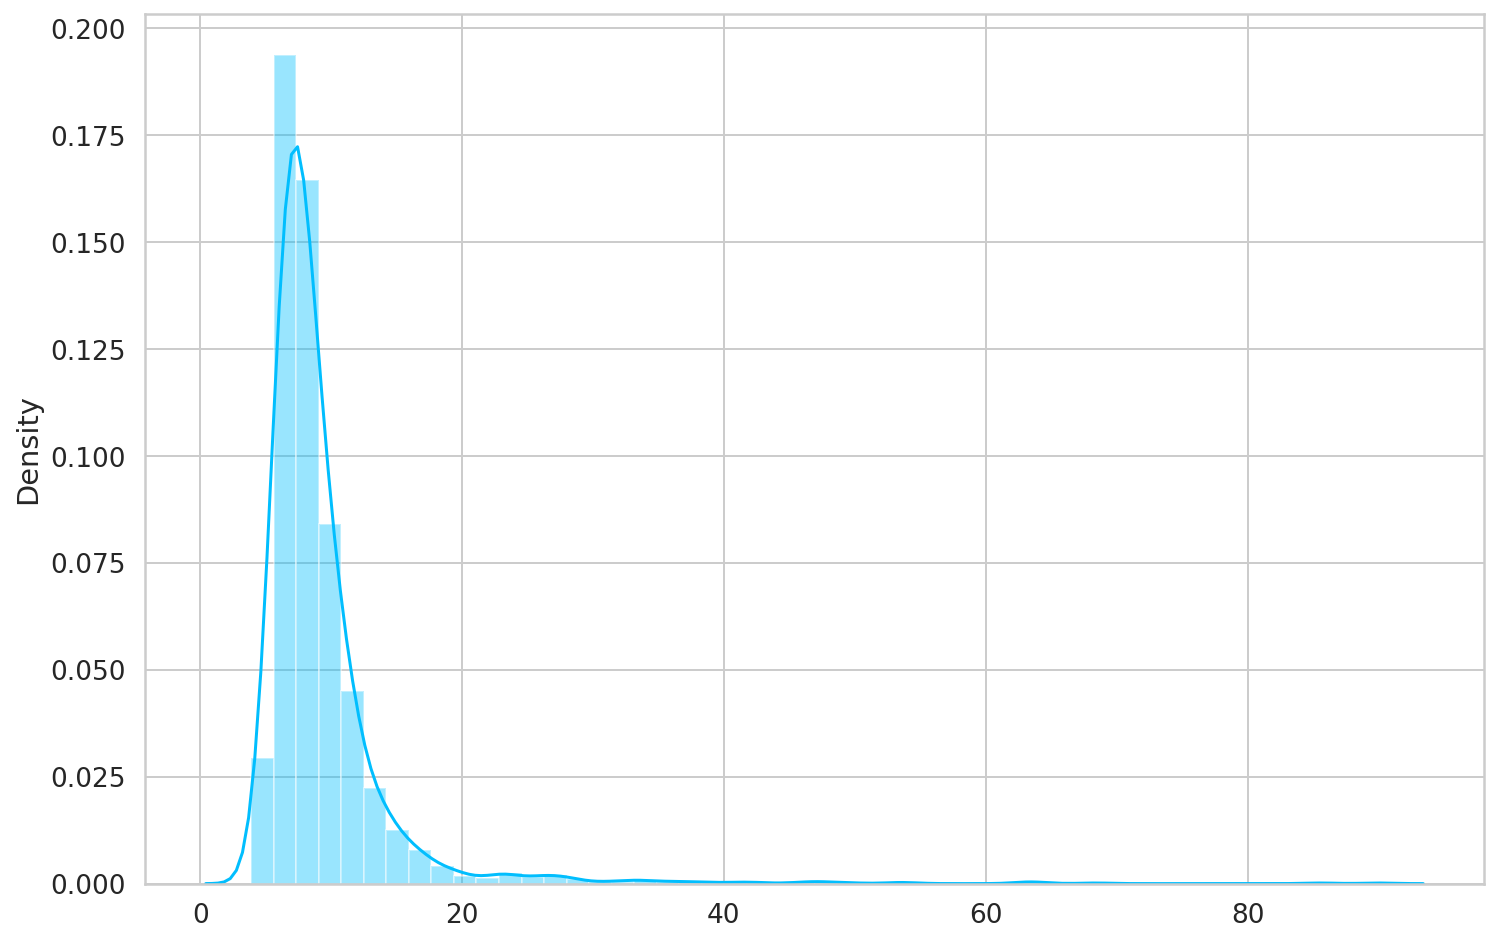

In [26]:
_, losses = predict(autoencoder_model, train_dataset)

sns.distplot(losses, bins=50, kde=True); # 3sigma

In [27]:
# train_df, val_df, test_df - are from normal_df

# THRESHOLD = 26
from math import ceil
import statistics

type(losses)

THRESHOLD = ceil(statistics.mean(losses) + 3 * statistics.stdev(losses))
MEDIAN = statistics.median(losses)
MEAN = statistics.mean(losses)
SD = statistics.stdev(losses)

print(f"median= {MEDIAN}, mean= {MEAN}, sd= {SD}, m+3sd= {THRESHOLD}")

median= 7.916231632232666, mean= 9.238669621084352, sd= 5.511281337792396, m+3sd= 26


## Evaluation

Using the threshold, we can turn the problem into a simple binary classification task:

- If the reconstruction loss for an example is below the threshold, we'll classify it as a *normal* heartbeat
- Alternatively, if the loss is higher than the threshold, we'll classify it as an anomaly

### Normal hearbeats

Let's check how well our model does on normal heartbeats. We'll use the normal heartbeats from the test set (our model haven't seen those):

In [35]:
len(test_normal_dataset[0])

140

In [39]:
# pd.DataFrame(test_normal_dataset)
print(test_normal_dataset[0])

tensor([[-0.7830],
        [-2.8876],
        [-4.0093],
        [-4.4484],
        [-4.0501],
        [-3.5267],
        [-2.3327],
        [-1.5487],
        [-1.3708],
        [-0.6997],
        [-0.4378],
        [-0.4940],
        [-0.4638],
        [-0.4451],
        [-0.3407],
        [-0.3579],
        [-0.3131],
        [-0.4896],
        [-0.4355],
        [-0.3922],
        [-0.4486],
        [-0.3330],
        [-0.4340],
        [-0.4134],
        [-0.3816],
        [-0.4946],
        [-0.4243],
        [-0.4178],
        [-0.4941],
        [-0.5542],
        [-0.6087],
        [-0.5971],
        [-0.6191],
        [-0.6605],
        [-0.6368],
        [-0.6832],
        [-0.6024],
        [-0.5649],
        [-0.4445],
        [-0.4087],
        [-0.3039],
        [-0.2953],
        [-0.3018],
        [-0.2048],
        [-0.1234],
        [-0.0729],
        [ 0.0117],
        [ 0.0085],
        [ 0.0495],
        [ 0.0692],
        [ 0.1286],
        [ 0.1485],
        [ 0.

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


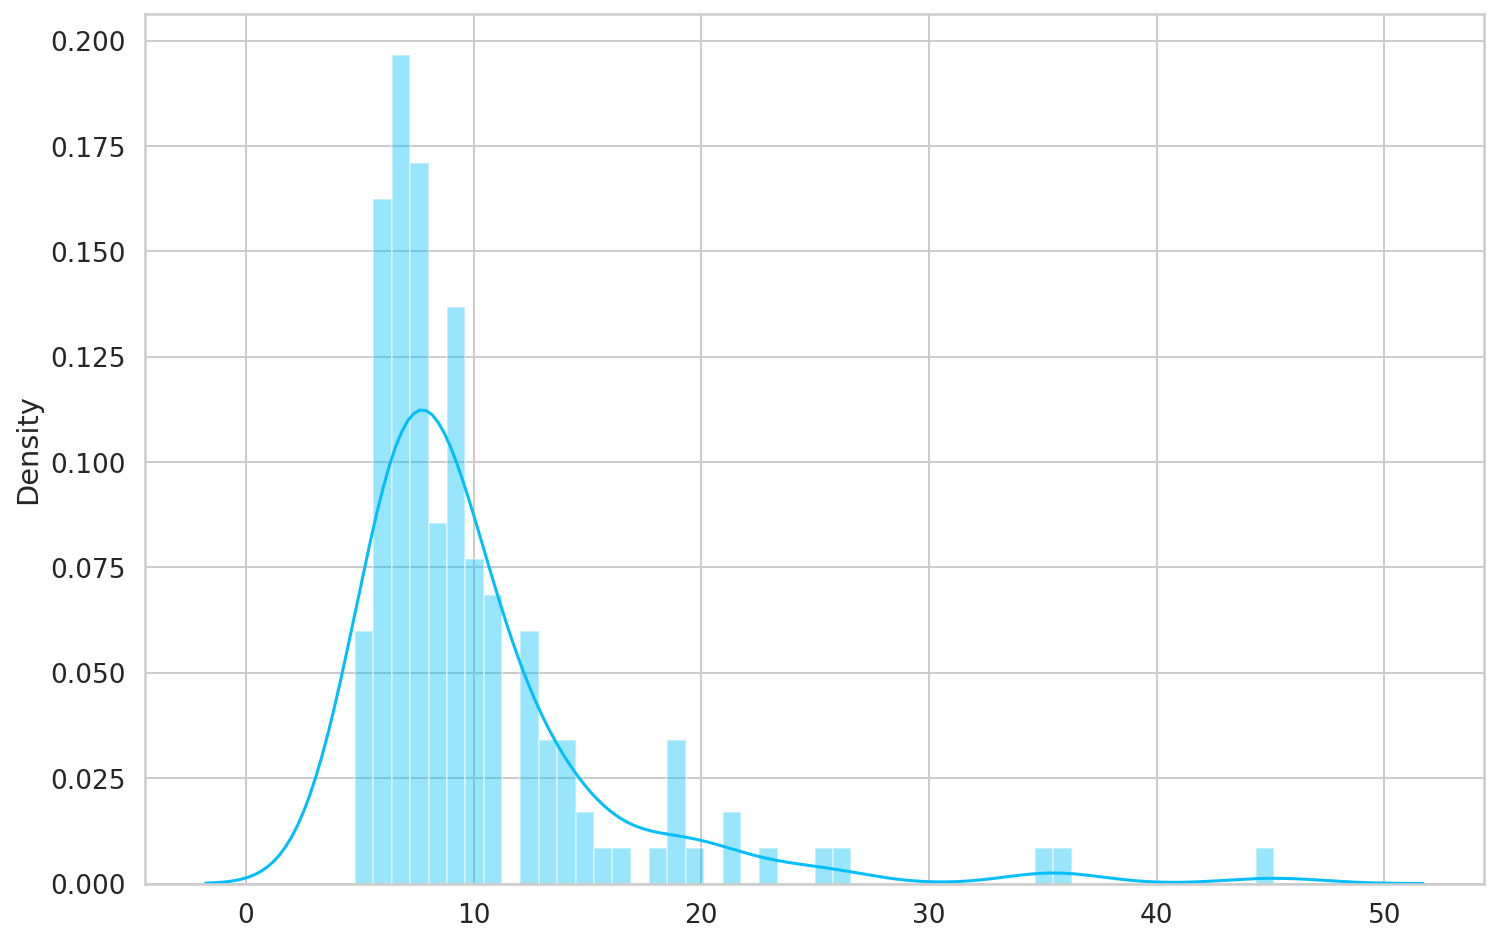

In [40]:
predictions, pred_losses = predict(autoencoder_model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

We'll count the correct predictions:

In [41]:
len(pred_losses)
# len(predictions[0])

145

In [42]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 142/145


### Anomalies

We'll do the same with the anomaly examples, but their number is much higher. We'll get a subset that has the same size as the normal heartbeats:

In [44]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]  ## to have the same amount of samples
# pd.DataFrame(anomaly_dataset)

Now we can take the predictions of our model for the subset of anomalies:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


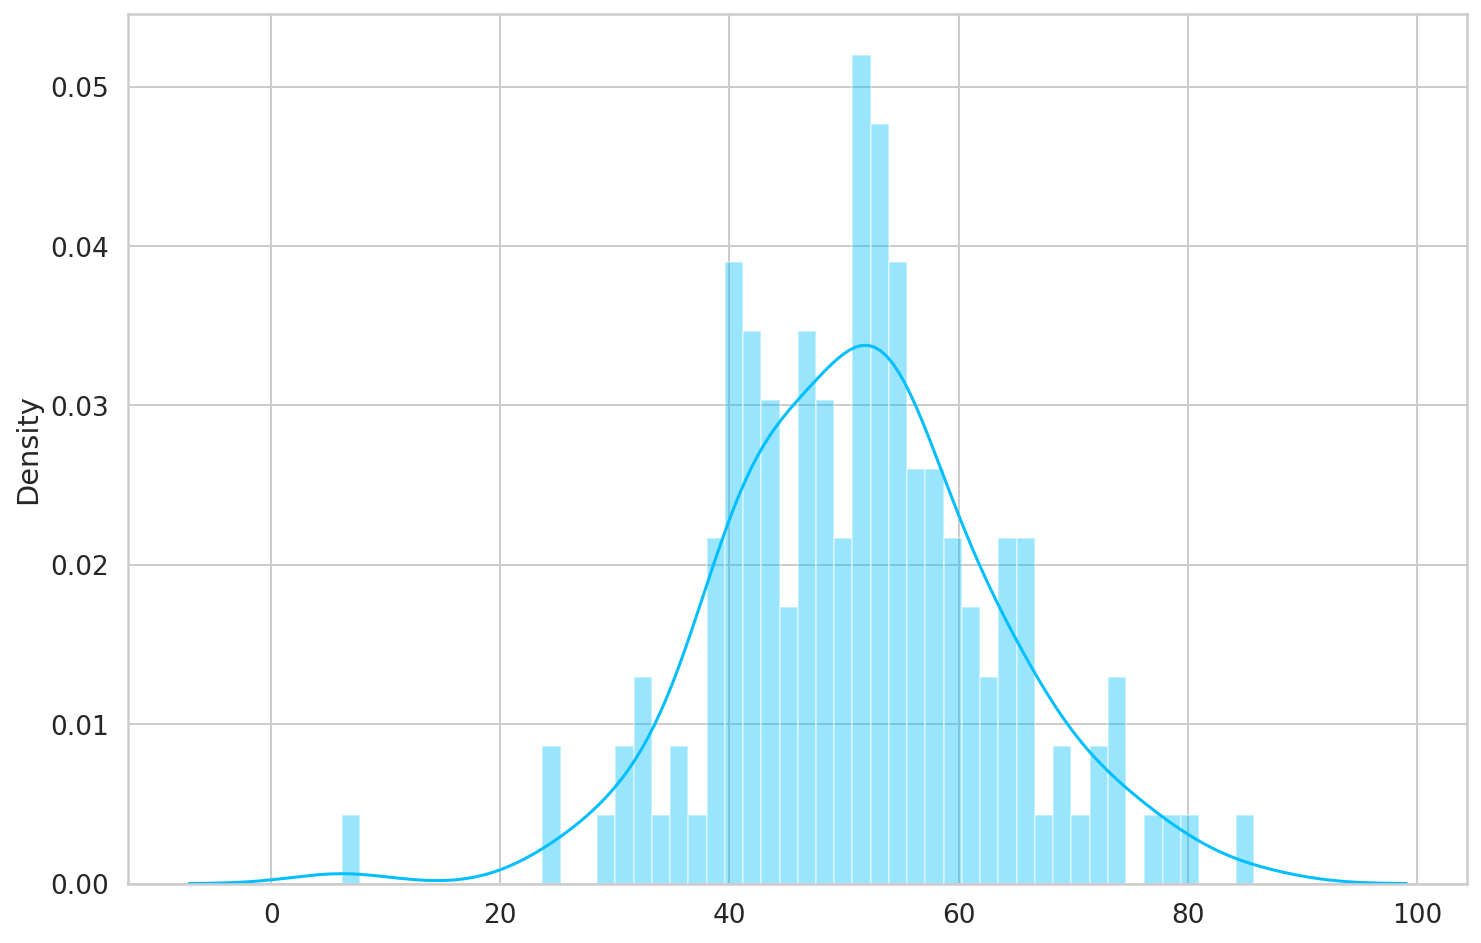

In [45]:
predictions, pred_losses = predict(autoencoder_model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

Finally, we can count the number of examples above the threshold (considered as anomalies):

In [45]:
len(predictions[0])

140

In [46]:
len(pred_losses)

145

In [46]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')
### przypadkowo wychodzi tak samo:

Correct anomaly predictions: 142/145


We have very good results. In the real world, you can tweak the threshold depending on what kind of errors you want to tolerate. In this case, you might want to have more false positives (normal heartbeats considered as anomalies) than false negatives (anomalies considered as normal).

#### Looking at Examples

We can overlay the real and reconstructed Time Series values to see how close they are. We'll do it for some normal and anomaly cases:

In [28]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  ax.plot(data, label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

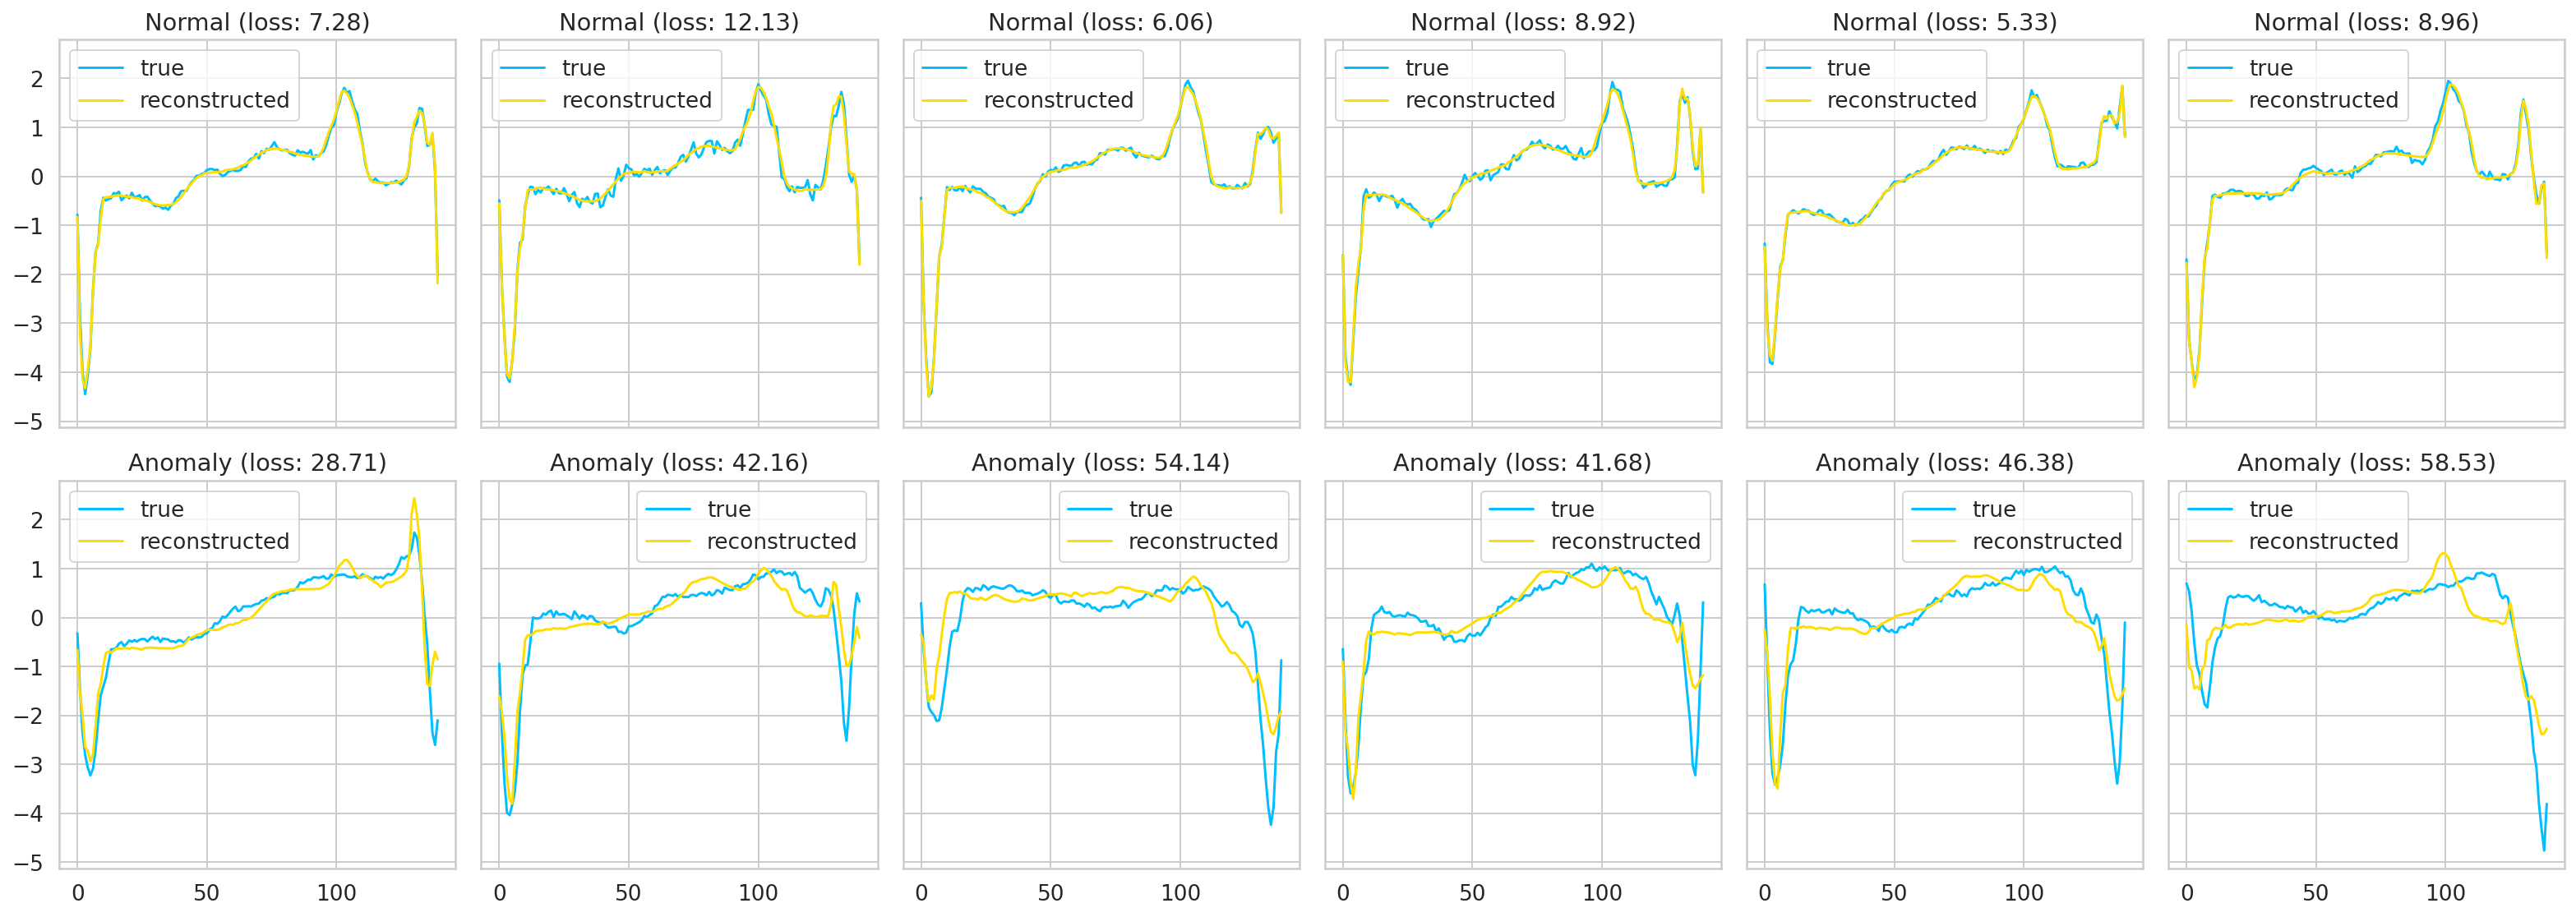

In [29]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction(data, autoencoder_model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
  plot_prediction(data, autoencoder_model, title='Anomaly', ax=axs[1, i])

fig.tight_layout()

In [30]:
_, pred_losses = predict(autoencoder_model, test_anomaly_dataset)

In [31]:
print(f"min_pred_losses= {min(pred_losses)}, max_pred_losses= {max(pred_losses)}")

min_pred_losses= 6.146759986877441, max_pred_losses= 162.87681579589844


In [51]:
from sklearn.base import BaseEstimator, ClassifierMixin
import scipy.stats

class BinaryClassifier(BaseEstimator, ClassifierMixin):

  def __init__(self, model, threshold, mean, sd):
    self.model = model
    self.threshold = threshold
    # self.mean = mean
    # self.sd = sd
    self.gauss = scipy.stats.norm(mean, sd)

  def fit(self, X, y=None):
    pass

  def predict(self, X, y=None):
    predictions, pred_losses = predict(autoencoder_model, X)
    return [int(l > self.threshold) for l in pred_losses]

  def predict_proba(self, X, y=None): # ???
    predictions, pred_losses = predict(autoencoder_model, X)
    # return [abs(l - self.threshold) / self.max_loss for l in pred_losses]
    return [1- self.gauss.pdf(l) for l in pred_losses]  # nie znamy rozkładu...

bc = BinaryClassifier(autoencoder_model, THRESHOLD, MEAN, SD)

In [52]:
print(bc.predict(test_anomaly_dataset[:30]))
print(bc.predict(test_normal_dataset[:30]))
# bc.predict_proba(test_anomaly_dataset[:100])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]


In [53]:
# print(bc.predict_proba(test_anomaly_dataset[:30]))
# print(bc.predict_proba(test_normal_dataset[:30]))

## Summary

In this tutorial, you learned how to create an LSTM Autoencoder with PyTorch and use it to detect heartbeat anomalies in ECG data.

- [Read the tutorial](https://www.curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1_J2MrBSvsJfOcVmYAN2-WSp36BtsFZCa)
- [Read the Getting Things Done with Pytorch book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

You learned how to:

- Prepare a dataset for Anomaly Detection from Time Series Data
- Build an LSTM Autoencoder with PyTorch
- Train and evaluate your model
- Choose a threshold for anomaly detection
- Classify unseen examples as normal or anomaly

While our Time Series data is univariate (we have only 1 feature), the code should work for multivariate datasets (multiple features) with little or no modification. Feel free to try it!

## References

- [Sequitur - Recurrent Autoencoder (RAE)](https://github.com/shobrook/sequitur)
- [Towards Never-Ending Learning from Time Series Streams](https://www.cs.ucr.edu/~eamonn/neverending.pdf)
- [LSTM Autoencoder for Anomaly Detection](https://towardsdatascience.com/lstm-autoencoder-for-anomaly-detection-e1f4f2ee7ccf)

In [32]:
n_features = len(test_normal_dataset[0])
n_features

140

In [33]:
df['binary_target'] = df['target'].apply(lambda x: 0 if x == CLASS_NORMAL else 1)
df[['binary_target', 'target']]

,binary_target,target
1001,0,1
2086,0,1
2153,0,1
555,0,1
205,0,1
...,...,...
3926,1,2
466,1,2
2592,0,1
3272,1,2


In [34]:
classfier_train_df, classfier_val_df = train_test_split(
  df,
  test_size=0.15,
  random_state=RANDOM_SEED
)
classfier_val_df, classfier_test_df = train_test_split(
  classfier_val_df,
  test_size=0.33,
  random_state=RANDOM_SEED
)

In [35]:
def get_X_and_y(mydf):
  return mydf.drop(labels=['binary_target', 'target'], axis=1), mydf['binary_target']

classfier_train_X, classfier_train_y = get_X_and_y(classfier_train_df)
classfier_val_X, classfier_val_y = get_X_and_y(classfier_val_df)
classfier_test_X, classfier_test_y = get_X_and_y(classfier_test_df)

# classfier_train_X.values
# classfier_train_y.values

In [58]:
# classfier_val_X
classfier_val_y

2449    0
47      0
245     0
2979    1
3074    1
       ..
2524    0
3710    1
2502    0
469     1
4101    1
Name: binary_target, Length: 502, dtype: int64

In [120]:
# def classfier_create_dataset(X, y):
#   dataset, seq_len, n_features = create_dataset(X)
#   return list(zip(dataset, [torch.tensor(yy) for yy in y])), seq_len, n_features
#
# classfier_train, seq_len, n_features = classfier_create_dataset(classfier_train_X, classfier_train_y)
# # print(classfier_train[0])
# print(classfier_train[1][1].item())

0


In [36]:
from torch.utils.data import Dataset, DataLoader


class classfier_dataset(Dataset):
  def __init__(self, x, y):
    self.x = torch.tensor(x.values, dtype=torch.float32)
    self.y = torch.tensor(y.values, dtype=torch.float32)
    self.length = self.x.shape[0]

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

  def __len__(self):
    return self.length


classfier_trainset = classfier_dataset(classfier_train_X, classfier_train_y)

In [37]:
#DataLoader
classfier_trainloader = DataLoader(classfier_trainset, batch_size=256, shuffle=False)

In [70]:
# classfier_trainset.__getitem__(0)
n_features

140

In [71]:
classfier_trainloader.__len__()

17

In [48]:
class Classifier(nn.Module):
  def __init__(self, autoencoder, n_features, device):
    super(Classifier, self).__init__()
    self.autoencoder = autoencoder
    for p in self.autoencoder.parameters():
      p.requires_grad = False
    self.classifier = nn.Sequential(
      nn.Linear(n_features, 32),
      nn.Linear(32, 16),
      nn.Dropout(0.2),
      nn.Linear(16, 1),
      nn.Dropout(0.2),
      nn.Sigmoid()
    ).to(device)

  # def forward(self, x):
  #   x = self.autoencoder(x)
  #   x = self.classifier(x)
  #   return x

  def forward(self, x):
    # print(f"x.size {x.size()}")
    n_batch = x.size()[0]
    # x.reshape(n_batch, n_features)
    decoded_list = []
    x_list = x.tolist()
    with torch.no_grad():
      # encoded = self.autoencoder.encoder(x)
      for xx in x_list:
        # print(xx)
        forward = self.autoencoder.forward(torch.tensor(xx).to(device)) # , dtype=torch.float32
        # print(f"forward.size {forward.size()}")
        decoded_list.append(forward)
    decoded = torch.stack(decoded_list).reshape(n_batch, n_features) # , dtype=torch.float32
    # print(f"decoded.size {decoded.size()}")
    delta = torch.add(x, decoded, alpha=-1).to(device)
    # print(f"delta.size {delta.size()}")
    out = self.classifier(delta)
    # print(f"out.size {out.size()}")
    return out

classifier = Classifier(autoencoder_model, n_features, device)

In [49]:
# criterion1 = nn.MSELoss()
criterion2 = nn.BCELoss()

# optimizer = optim.Adam(classifier.parameters(), lr=0.01)
optimizer = torch.optim.SGD(classifier.parameters(), lr=0.01)

epochs = 4
losses = []
accur = []

for i in range(epochs):
  for j, (x_train, y_train) in enumerate(classfier_trainloader):
    optimizer.zero_grad()
    # inputs = Variable(inputs)
    # labels = Variable(labels)
    # print(inputs)
    # print(labels)
    x_train, y_train = x_train.to(device), y_train.reshape(-1, 1).to(device)
    # print(f"x_train.size {x_train.size()}")
    # print(f"y_train.size {y_train.size()}")

    output = classifier(x_train)
    loss = criterion2(output, y_train)

    # print(out)
    # loss1 = criterion1(decoded, inputs)
    # loss = criterion2(out, labels)
    # loss = loss1 + loss2
    loss.backward()
    optimizer.step()
    with torch.no_grad():
      predicted = classifier(torch.tensor(classfier_test_X.values).to(device).float()) # , dtype=torch.float32
      acc = (predicted.reshape(-1).detach().cpu().numpy().round() == classfier_test_y.values).mean()

    if i % 1 == 0 and j % 15 == 0:
      losses.append(loss)
      accur.append(acc)
      print("epoch {} batch {} \tloss : {}\t accuracy : {}".format(i, j, loss, acc))

epoch 0 batch 0 	loss : 0.7005749940872192	 accuracy : 0.5887096774193549
epoch 0 batch 15 	loss : 0.6689687967300415	 accuracy : 0.6612903225806451
epoch 1 batch 0 	loss : 0.6571180820465088	 accuracy : 0.6532258064516129
epoch 1 batch 15 	loss : 0.6347038745880127	 accuracy : 0.7540322580645161
epoch 2 batch 0 	loss : 0.6282327175140381	 accuracy : 0.7620967741935484
epoch 2 batch 15 	loss : 0.6145190000534058	 accuracy : 0.8225806451612904
epoch 3 batch 0 	loss : 0.5945141315460205	 accuracy : 0.8306451612903226
epoch 3 batch 15 	loss : 0.5712714195251465	 accuracy : 0.8830645161290323


In [50]:
CLASSFIER_MODEL_PATH = f'{DATA_DIRECTORY}classifier_model.pth'

In [51]:
torch.save(classifier, CLASSFIER_MODEL_PATH)

In [113]:
# LOAD classifier MODEL
classifier = torch.load(CLASSFIER_MODEL_PATH)
classifier = classifier.to(device)
classifier

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [52]:
classfier_valset = classfier_dataset(classfier_val_X, classfier_val_y)
#DataLoader
# classfier_valloader = DataLoader(classfier_valset, batch_size=1,shuffle=False)
classfier_valset[4][0].reshape(1,-1).shape

torch.Size([1, 140])

In [55]:
classifier(classfier_valset[4][0].reshape(1,-1).to(device))

tensor([[0.6597]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [56]:
classfier_valset[4][0].reshape(1,-1).to(device)

tensor([[-2.9186e-01, -1.1448e+00, -1.6147e+00, -2.3075e+00, -2.5603e+00,
         -2.7621e+00, -2.7021e+00, -2.3768e+00, -1.8856e+00, -1.3700e+00,
         -1.0157e+00, -7.5282e-01, -6.1966e-01, -5.0573e-01, -1.8911e-01,
          1.8567e-01,  3.6596e-01,  2.9550e-01,  1.8298e-01,  3.2913e-01,
          3.2632e-01,  2.5010e-01,  4.1693e-01,  3.3780e-01,  2.6731e-01,
          3.4688e-01,  2.6022e-01,  2.5962e-01,  3.3871e-01,  3.4079e-01,
          3.5892e-01,  3.5531e-01,  2.9965e-01,  3.1532e-01,  3.3856e-01,
          3.0462e-01,  3.4783e-01,  3.3159e-01,  2.7949e-01,  3.4612e-01,
          2.6610e-01,  1.9124e-01,  2.5404e-01,  2.4032e-01,  2.7150e-01,
          2.7078e-01,  1.5349e-01,  1.2322e-01,  1.3782e-01,  1.1869e-01,
          1.2695e-01,  7.0726e-02,  4.6994e-04,  5.0166e-02,  5.8189e-02,
          1.5627e-02,  3.0303e-02, -1.8075e-02, -3.5015e-02,  1.5601e-02,
         -6.6878e-02, -1.1238e-01, -3.7889e-02, -3.5173e-02, -6.6083e-02,
         -1.2666e-02,  6.7777e-02,  7.

In [57]:
classifier(classfier_valset[1][0].reshape(1,-1).to(device)).reshape(-1)

tensor([0.4240], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)

In [58]:
classifier(torch.stack([classfier_valset[i][0] for i in range(5)]).to(device))

tensor([[0.3960],
        [0.4064],
        [0.4199],
        [0.5000],
        [0.6649]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [75]:
classifier(classfier_valset[5][0].reshape(1,-1).to(device))

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [60]:
classfier_valset[4][1].reshape(1,-1).reshape(-1)

tensor([1.])

In [73]:
def get_expl(model, device, input, target, delta=0.007):
  n_samples = len(input)
  n_features = len(input[0])
  # n_samples = 1
  # n_features = len(input)

  # input = data[index][0].view(-1, 3000, 2).to(device)
  # target = data[index][1]
  input = input.to(device).float()
  target = target.to(device).type(torch.int64)
  baseline = torch.zeros(n_samples, n_features).to(device) # , dtype=torch.float64
  print(f"input.size {input.size()}")
  print(f"target.size {target.size()}")
  print(f"baseline.size {baseline.size()}")

  model.train()
  try:
    expl_ = GradientShap(model)  # , multiply_by_inputs=False
    attributions = expl_.attribute(inputs=input, baselines=baseline, target=target, n_samples=5)  #

    print(type(attributions))
  finally:
    _ = model.eval()

  print('Target:', target)
  print('Attributions:', attributions.shape)

  data = input#.view(-1, 2).transpose(0,1).cpu().detach().numpy()
  data[attributions.abs().cpu().detach().numpy()[0] < delta] = np.nan

  plt.plot(range(input.shape[1]), input.cpu().detach().numpy()[0])
  plt.plot(range(data.shape[0]), data)
  plt.show()


In [74]:
# len(test_normal_dataset)
# test_normal_dataset[144]
# get_expl(classifier, device, classfier_valset[4][0].reshape(1,-1), classfier_valset[4][1].reshape(1,-1).reshape(-1).type(torch.int64), delta=0.007)
# get_expl(classifier, device, classfier_valset[4][0].reshape(1,-1), classfier_valset[4][1].reshape(1,-1), delta=0.007)
get_expl(classifier, device, torch.stack([classfier_valset[i][0] for i in range(5)]), torch.stack([classfier_valset[i][1] for i in range(5)]), delta=0.007)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [72]:
classfier_valset

In [117]:
import sys
sys.path.append('..')
from inxai import *

gm = GlobalFeatureMetric()

In [122]:
df_x_5 = pd.DataFrame(torch.stack([classfier_valset[i][0] for i in range(5)]).numpy())
df_y_5 = pd.DataFrame(torch.stack([classfier_valset[i][1] for i in range(5)]).numpy())
# df_x_5

In [ ]:
class ClassifierWrapper(BaseEstimator, ClassifierMixin):

  def __init__(self, torch_classifier):
    self.model = torch_classifier

  def fit(self, X, y=None):
    pass

  def predict(self, X, y=None):
    predictions, pred_losses = predict(autoencoder_model, X)
    return [int(l > self.threshold) for l in pred_losses]

  def predict_proba(self, X, y=None):
    predictions, pred_losses = predict(autoencoder_model, X)
    # return [abs(l - self.threshold) / self.max_loss for l in pred_losses]
    return [1- self.gauss.pdf(l) for l in pred_losses]

bc = BinaryClassifier(autoencoder_model, THRESHOLD, MEAN, SD)

In [ ]:
shap_res=generate_per_instance_importances(models=classifier, X=X_test_appended, y=y_test_appended, framework='kernel_shap')

In [ ]:
# 1 uzyc metryk
# 2 AUC POC - jak zrobic perturbacje?
# LUB research jak interpretowac metryki zeby wiedziec cos wiecej (Grzegorz Huk - praca mgr)

# ART == co mozemy sie dowiedziec o modelu / danych, n.p. skorelowane szeregi itp
# zmienna confunder - powiązana z inną, ale nie liniowa korelacja - SHAP dzieli porówno;  causal ML


# Doctoral consortium:
# - dorobic cokolwiek do IJCAI
# - casual ML
# - counterfactual